# Mean profiles from CNV files

In [29]:
import unisacsi.Ocean as Oc
#import unisacsi.Meteo as Met
#from unisacsi.MET_model_download import download_MET_model_static_fields, download_MET_model_data
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import gsw
import cmocean as cmo
import scipy.interpolate as interp

plt.rcParams["font.family"] = "times new roman"

In [8]:
def compute_mean(CTD, variable, stationnames):
    CTD_i,Z,_,_ = Oc.CTD_to_grid(CTD, stationnames,interp_opt=0)
    df = pd.DataFrame(CTD_i[variable],index=Z
                    ,columns=stationnames
                   )
    df = df[1:]
    df_mean = df.mean(axis=1)
    
    return df, df_mean

In [9]:
def plot_profiles(df, df_mean, ax):
    ax.plot(df, df.index, color='Gray', alpha=.5)
    ax.plot(df_mean, df_mean.index, lw=2)

    ax.invert_yaxis()

In [10]:
def smooth_profile(df_mean, mld, window=5):
    mixed = df_mean[:mld].mean()
    df_smooth = df_mean.rolling(window=window, center=True).mean()
    
    df_smooth[:mld] = mixed
    
    return df_smooth

In [11]:
def create_initial_ocean(depth, T_mean, S_mean, depth_new):
    interpolater = interp.interp1d(depth, T_mean, fill_value = "extrapolate")
    T_new = interpolater(depth_new)
    
    interpolater = interp.interp1d(depth, S_mean, fill_value = "extrapolate")
    S_new = interpolater(depth_new)

    data = {'depth': model_depth, 'temp':T_new, 'salinity':S_new}
    dataFrame = pd.DataFrame(data)
    return dataFrame

In [12]:
# path to cnv-files. Should be on the format Sta0001.cnv (Sta followed by four digits)
path_data = '../../data/CTD/Adventfjorden/221103/'

In [13]:
# Read in files
CTD = Oc.read_CTD(path_data)
stations = [f'{i}' for i in CTD.keys()]

In [18]:
# print(CTD[stations[0]].keys()) # displays variables saved at first (each) station

dict_keys(['P', 'T', 'C', 'OX', 'S', 'SIGTH', 'Cs', 'sbe_model', 'gps_datetime', 'seasave', 'instrument_type', 'nquan', 'nvalues', 'start_time', 'bad_flag', 'file_type', 'md5', 'datetime', 'filename', 'dnum', 'LAT', 'LON', 'z', 'BottomDepth', 'SA', 'CT', 'st', 'unis_st'])


3.575
3.5724201992566056


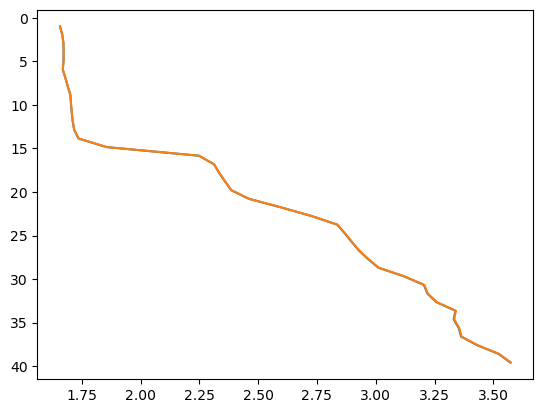

In [14]:
# Converting in-situ temperature to potential temperature 

for station in stations:
    T = CTD[station]['T']
    S = CTD[station]['S']
    P = CTD[station]['P']
    z = CTD[station]['z']
    
    # calculate potential temperature
    PT = gsw.conversions.pt0_from_t(S, T, P)
    CTD[station]['PT'] = PT


print(T[-1])
print(PT[-1])
plt.figure()
plt.plot(PT,-z)
plt.plot(T,-z)
plt.gca().invert_yaxis()

Text(0.5, 0, 'Density')

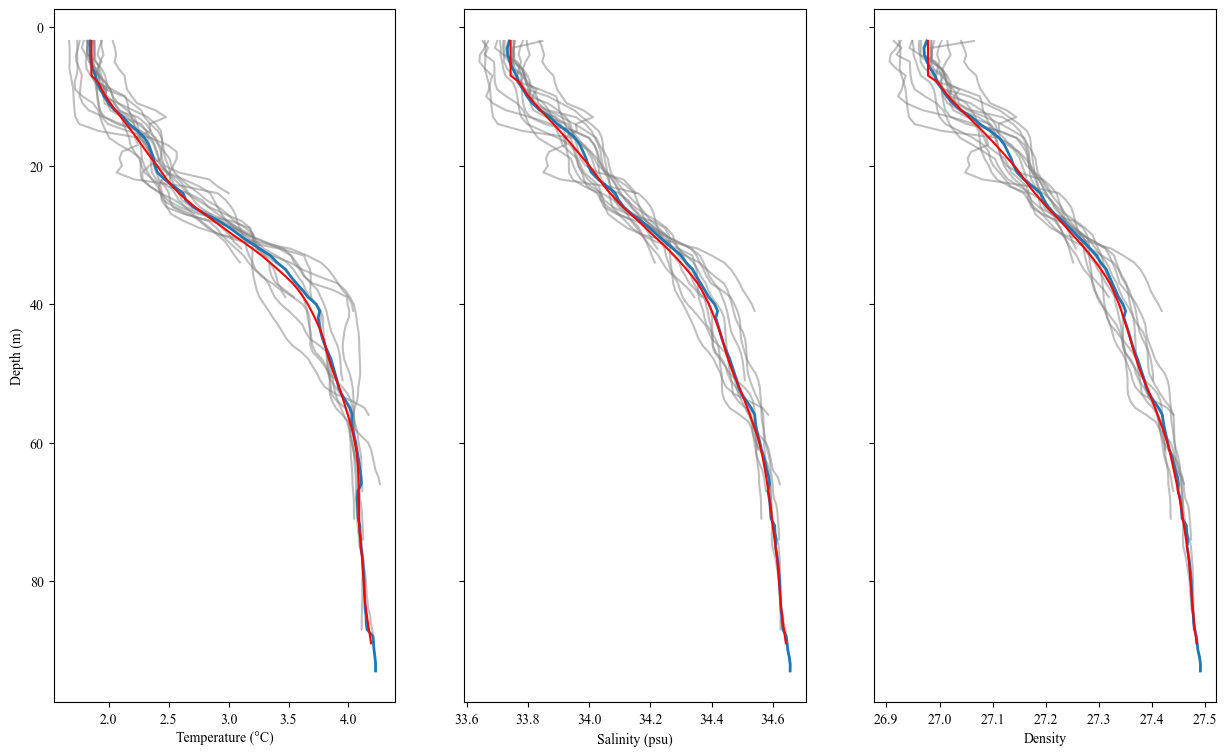

In [30]:
window = 10
mld=7

dfT, dfT_mean = compute_mean(CTD, 'T', stations)
dfS, dfS_mean = compute_mean(CTD, 'S', stations)
dfs, dfs_mean = compute_mean(CTD, 'SIGTH', stations)

dfT_smooth = smooth_profile(dfT_mean, mld, window)
dfS_smooth = smooth_profile(dfS_mean, mld, window)
dfs_smooth = smooth_profile(dfs_mean, mld, window)

fig, [axT, axS, axs] = plt.subplots(1,3, sharey=True, figsize=(15,9))
plot_profiles(dfT, dfT_mean, axT)
plot_profiles(dfS, dfS_mean, axS)
plot_profiles(dfs, dfs_mean, axs)

axT.plot(dfT_smooth, dfT_smooth.index, color='red')
axS.plot(dfS_smooth, dfs_smooth.index, color='red')
axs.plot(dfs_smooth, dfs_smooth.index, color='red')
axT.set_ylabel('Depth (m)')
axT.set_xlabel('Temperature (\N{DEGREE SIGN}C)')
axS.set_xlabel('Salinity (psu)')
axs.set_xlabel('Density')

In [62]:
dfT_smooth

1.989480     1.854287
2.989484     1.854287
3.989488     1.854287
4.989491     1.854287
5.989495     1.854287
               ...   
88.989799    4.189041
89.989802         NaN
90.989806         NaN
91.989810         NaN
92.989813         NaN
Length: 92, dtype: float64

In [57]:
dfT_smooth.values[0]

1.854287326535264

In [85]:
# create file with initial ocean conditions (depth, meanT, meanS)
dataFrame = create_initial_ocean(dfT_smooth.index, dfT_smooth.values, dfS_smooth.values, model_depth)
print(dataFrame_T)
dataFrame.to_csv("../../data/CTD_processed/mean_profile_221103.csv")

    depth      temp   salinity
0       0  2.359237  33.997124
1       2  2.359237  33.997124
2       4  2.359237  33.997124
3       6  2.359237  33.997124
4       8  2.388472  34.005924
5      10  2.422906  34.016211
6      12  2.463723  34.028356
7      14  2.520653  34.044732
8      16  2.587736  34.063904
9      18  2.662657  34.085660
10     20  2.746140  34.109747
11     22  2.836033  34.135117
12     24  2.929898  34.161772
13     26  3.022147  34.189220
14     28  3.105347  34.214872
15     30  3.181279  34.238513
16     32  3.247172  34.259799
17     34  3.298708  34.277831
18     36  3.334805  34.291537
19     38  3.358331  34.301655
20     40  3.371624  34.308984
21     42  3.376470  34.314042
22     44  3.388276  34.319622
23     46  3.408634  34.326471
24     48  3.428996  34.333608
25     50  3.453327  34.340766
26     52  3.482674  34.348935
27     54  3.509363  34.357072
28     56  3.536958  34.365590
29     58  3.574427  34.376801
30     60  3.625561  34.391276
31     6

In [73]:
path_data = '../../data/CTD/Adventfjorden/221031/'
# Read in files
CTD = Oc.read_CTD(path_data)
stations = [f'{i}' for i in CTD.keys()]

Text(0.5, 0, 'Density')

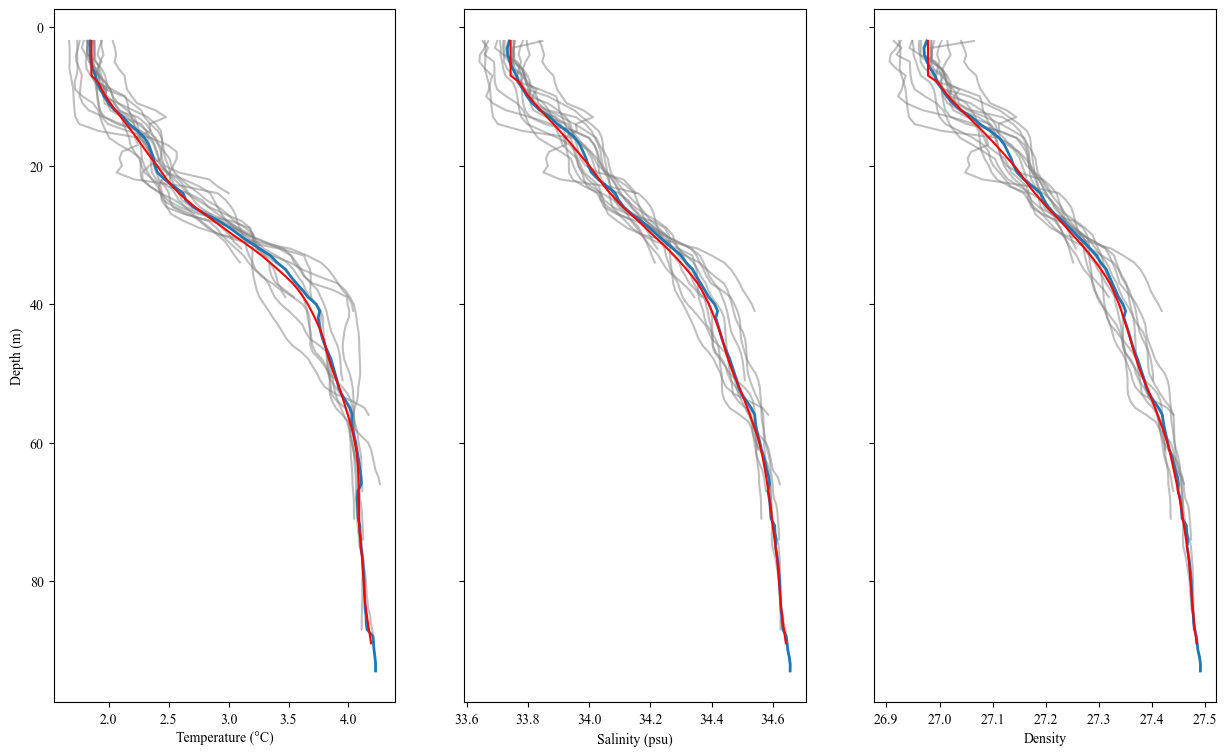

In [31]:
dfT, dfT_mean = compute_mean(CTD, 'T', stations)
dfS, dfS_mean = compute_mean(CTD, 'S', stations)
dfs, dfs_mean = compute_mean(CTD, 'SIGTH', stations)

dfT_smooth = smooth_profile(dfT_mean, mld, window)
dfS_smooth = smooth_profile(dfS_mean, mld, window)
dfs_smooth = smooth_profile(dfs_mean, mld, window)

fig, [axT, axS, axs] = plt.subplots(1,3, sharey=True, figsize=(15,9))
plot_profiles(dfT, dfT_mean, axT)
plot_profiles(dfS, dfS_mean, axS)
plot_profiles(dfs, dfs_mean, axs)

axT.plot(dfT_smooth, dfT_smooth.index, color='red')
axS.plot(dfS_smooth, dfs_smooth.index, color='red')
axs.plot(dfs_smooth, dfs_smooth.index, color='red')
axT.set_ylabel('Depth (m)')
axT.set_xlabel('Temperature (\N{DEGREE SIGN}C)')
axS.set_xlabel('Salinity (psu)')
axs.set_xlabel('Density')

In [ ]:
# create file with initial ocean conditions (depth, meanT, meanS)
dataFrame = create_initial_ocean(dfT_smooth.index, dfT_smooth.values, dfS_smooth.values, model_depth)
print(dataFrame_T)
dataFrame.to_csv("../../data/CTD_processed/mean_profile_221031.csv")